In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('clean_weather.csv')
df.columns=['Date','tmax','tmin','rain','tmax_tomorrow']
df.head(10)

,Date,tmax,tmin,rain,tmax_tomorrow
0,1970-01-01,60.0,35.0,0.00,52.0
1,1970-01-02,52.0,39.0,0.00,52.0
2,1970-01-03,52.0,35.0,0.00,53.0
3,1970-01-04,53.0,36.0,0.00,52.0
4,1970-01-05,52.0,35.0,0.00,50.0
5,1970-01-06,50.0,38.0,0.00,52.0
6,1970-01-07,52.0,43.0,0.00,56.0
7,1970-01-08,56.0,49.0,0.24,54.0
8,1970-01-09,54.0,50.0,0.40,57.0
9,1970-01-10,57.0,50.0,0.00,57.0


In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13509 entries, 0 to 13508
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           13509 non-null  object 
 1   tmax           13498 non-null  float64
 2   tmin           13495 non-null  float64
 3   rain           13228 non-null  float64
 4   tmax_tomorrow  13498 non-null  float64
dtypes: float64(4), object(1)
memory usage: 527.8+ KB


In [5]:
df.isna().sum()

Date               0
tmax              11
tmin              14
rain             281
tmax_tomorrow     11
dtype: int64

In [6]:
df = df.interpolate(method='linear')

C:\Users\ramch\AppData\Local\Temp\ipykernel_33276\2145716054.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


In [7]:
df.isna().sum()

Date             0
tmax             0
tmin             0
rain             0
tmax_tomorrow    0
dtype: int64

In [8]:
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y%m%d').astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13509 entries, 0 to 13508
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           13509 non-null  int32  
 1   tmax           13509 non-null  float64
 2   tmin           13509 non-null  float64
 3   rain           13509 non-null  float64
 4   tmax_tomorrow  13509 non-null  float64
dtypes: float64(4), int32(1)
memory usage: 475.1 KB


In [10]:
def prepare_data(timeseries_data, steps):
    X, y = [], []

    for i in range(len(timeseries_data)):
        if i+steps > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:i+steps], timeseries_data[i+steps: i+1+steps]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [11]:
df[10:11]

,Date,tmax,tmin,rain,tmax_tomorrow
10,19700111,57.0,50.0,0.31,58.0


In [12]:
max = df['tmax']

In [81]:
X, y = prepare_data(max, 730)

In [82]:
X.shape, X.dtype

((12779, 730), dtype('float64'))

In [83]:
X.reshape(X.shape[0], X.shape[1], 1)

array([[[60.],
        [52.],
        [52.],
        ...,
        [50.],
        [50.],
        [55.]],

       [[52.],
        [52.],
        [53.],
        ...,
        [50.],
        [55.],
        [60.]],

       [[52.],
        [53.],
        [52.],
        ...,
        [55.],
        [60.],
        [54.]],

       ...,

       [[67.],
        [65.],
        [69.],
        ...,
        [60.],
        [62.],
        [67.]],

       [[65.],
        [69.],
        [65.],
        ...,
        [62.],
        [67.],
        [66.]],

       [[69.],
        [65.],
        [64.],
        ...,
        [67.],
        [66.],
        [70.]]])

In [84]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, SimpleRNN

In [85]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# X_transformed = scaler.fit_transform(X)

In [91]:
from kerastuner import HyperModel, RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization

def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 5)):  
        model.add(Dense(
            units=hp.Int('units_' + str(i), min_value=16, max_value=512, step=32),
            activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(
                     hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mse',
                  metrics=['mse'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X, y, epochs=10, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 07s]
val_mse: 35.1329460144043

Best val_mse So Far: 33.47536849975586
Total elapsed time: 00h 01m 29s


c:\Users\ramch\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [87]:
def check_output(num):
    X_test, y_test = max[num-730:num], max[num: num+1]
    X_test = np.array(X_test).reshape(1,730,1)
    y_pred = best_model.predict(X_test, verbose=0)
    return round(y_pred[0][0],1), 'hi', y_test

In [88]:
X.shape

(12779, 730)

In [92]:
check_output(1400)

(64.8,
 'hi',
 1400    61.0
 Name: tmax, dtype: float64)

In [93]:
temp_input=(list(np.array(max[-730:])))
temp_input

[65.0,
 64.0,
 64.0,
 64.0,
 64.0,
 66.0,
 66.0,
 66.0,
 64.0,
 64.0,
 79.0,
 73.0,
 71.0,
 64.0,
 57.0,
 60.0,
 60.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 66.0,
 61.0,
 64.0,
 65.0,
 57.0,
 62.0,
 61.0,
 63.0,
 61.0,
 60.0,
 56.0,
 62.0,
 60.0,
 57.0,
 56.0,
 62.0,
 59.0,
 59.0,
 59.0,
 61.0,
 60.0,
 62.0,
 61.0,
 62.0,
 66.0,
 71.0,
 67.0,
 71.0,
 74.0,
 83.0,
 69.0,
 68.0,
 59.0,
 57.0,
 59.0,
 56.0,
 57.0,
 54.0,
 56.0,
 57.0,
 57.0,
 60.0,
 63.0,
 67.0,
 62.0,
 60.0,
 63.0,
 67.0,
 70.0,
 69.0,
 60.0,
 60.0,
 61.0,
 60.0,
 62.0,
 63.0,
 59.0,
 61.0,
 60.0,
 68.0,
 66.0,
 60.0,
 64.0,
 66.0,
 77.0,
 84.0,
 76.0,
 67.0,
 64.0,
 65.0,
 73.0,
 70.0,
 66.0,
 64.0,
 65.0,
 67.0,
 61.0,
 63.0,
 62.0,
 62.0,
 56.0,
 60.0,
 65.0,
 59.0,
 62.0,
 59.0,
 59.0,
 59.0,
 59.0,
 64.0,
 59.0,
 64.0,
 63.0,
 69.0,
 66.0,
 61.0,
 67.0,
 74.0,
 72.0,
 62.0,
 74.0,
 82.0,
 82.0,
 62.0,
 61.0,
 61.0,
 56.0,
 61.0,
 59.0,
 62.0,
 59.0,
 63.0,
 66.0,
 65.0,
 60.0,
 65.0,
 63.0,
 61.0,
 63.0,
 75.0,

In [101]:
# demonstrate prediction for next 10 days
x_input = np.array(max[-730:])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<1095):
    
    if(len(temp_input)>730):
        x_input=np.array(temp_input[1:])
        x_input = x_input.reshape((1, 730, 1))
        
        yhat = best_model.predict(x_input, verbose=0)
        
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        
        lst_output.append(round(yhat[0][0],1))
        i=i+1
    else:
        x_input = x_input.reshape((1, 730, 1))
        yhat = best_model.predict(x_input, verbose=0)
        temp_input.append(yhat[0][0])
        lst_output.append(round(yhat[0][0],1))
        i=i+1
    

print(lst_output)

[61.0, 60.6, 59.9, 59.2, 59.3, 59.2, 58.7, 59.3, 59.1, 58.9, 58.2, 58.1, 58.3, 58.1, 57.9, 57.9, 57.2, 57.3, 57.7, 58.0, 58.1, 58.7, 57.9, 57.7, 56.7, 57.0, 56.8, 56.4, 57.1, 57.4, 57.7, 57.8, 57.4, 57.2, 57.2, 57.4, 57.5, 57.4, 58.0, 57.4, 57.7, 58.4, 58.4, 57.9, 58.2, 58.3, 58.2, 58.7, 58.4, 58.5, 58.8, 59.5, 59.1, 58.9, 59.3, 59.0, 58.9, 59.4, 59.6, 59.6, 58.8, 58.6, 58.7, 58.8, 59.4, 59.7, 59.8, 59.6, 60.1, 60.2, 60.2, 60.2, 60.3, 60.8, 60.5, 61.0, 61.0, 60.8, 60.2, 60.8, 60.9, 61.5, 61.8, 62.4, 62.4, 62.2, 61.7, 61.5, 61.4, 61.6, 61.9, 62.3, 62.8, 62.8, 62.6, 63.2, 62.6, 62.9, 63.7, 63.5, 63.4, 63.8, 64.2, 63.7, 63.5, 63.8, 64.0, 63.8, 64.0, 64.5, 64.9, 64.3, 64.0, 63.9, 63.5, 64.4, 64.2, 64.8, 63.9, 63.6, 63.9, 65.1, 65.6, 65.7, 65.6, 65.7, 66.2, 65.6, 65.9, 66.3, 65.8, 65.4, 65.6, 65.8, 65.4, 65.7, 66.1, 65.9, 65.4, 65.3, 64.9, 65.1, 65.9, 65.3, 64.8, 65.4, 65.9, 66.4, 67.0, 66.7, 66.8, 67.4, 67.2, 67.1, 66.8, 66.4, 66.2, 65.9, 66.5, 66.5, 66.2, 67.1, 67.5, 67.5, 67.0, 66.0, 66.

In [102]:
import matplotlib.pyplot as plt
day_new=np.arange(0, 1460)
day_pred=np.arange(730,1825)

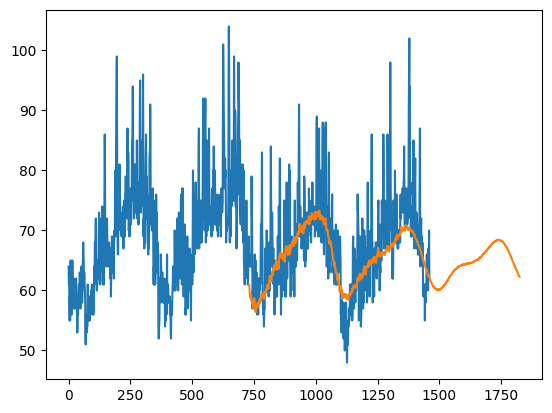

In [103]:
plt.plot(day_new,max[-1460:])
plt.plot(day_pred,lst_output)
